<a href="https://colab.research.google.com/github/kurexi/fml-labs/blob/main/FML_Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7


## Support Vector Machines (SVM)

In [ ]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] * faces.images.shape[2])

### Clas Balance

<BarContainer object of 5 artists>

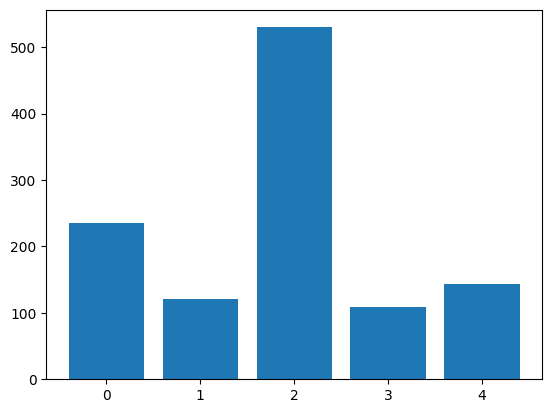

In [ ]:
import matplotlib.pyplot as plt

target = faces.target

# Count target
count = {}

for i in target:
  if i not in count.keys():
    count[i] = 0
  count[i] = count[i] + 1

plt.bar(count.keys(), count.values())

Iter-class variance Before: 0.02996985614299774
Iter-class variance After: 0.03010060265660286
---------
Itra-class variance for class 2
Before: 0.02987937442958355
After:  0.02987937442958355
---------
Itra-class variance for class 3
Before: 0.02986890822649002
After:  0.02985839918255806
---------
Itra-class variance for class 1
Before: 0.03027825430035591
After:  0.030250266194343567
---------
Itra-class variance for class 4
Before: 0.030501224100589752
After:  0.0304412841796875
---------
Itra-class variance for class 0
Before: 0.028877828270196915
After:  0.028906075283885002


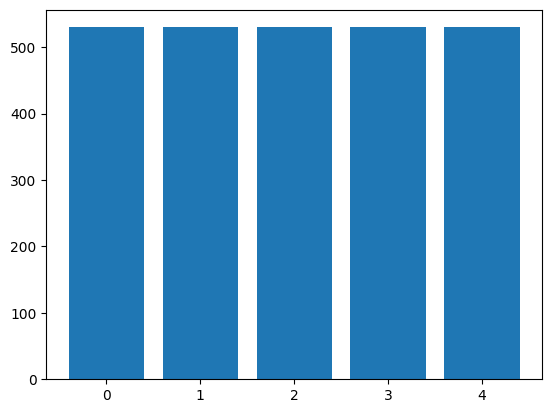

In [ ]:
import numpy as np

balanced_data = np.copy(faces.data)
balanced_target = np.copy(faces.target)

# Padding
max_amount = max(count.values())
for key in count:
  current_len = len(balanced_target[balanced_target == key])
  while current_len < max_amount:
    if max_amount / current_len >= 2:
      # Data
      balanced_data = np.vstack((np.array(balanced_data[balanced_target == key]), balanced_data))

      # Target
      balanced_target = np.hstack((np.array(balanced_target[balanced_target == key]), balanced_target))
    else:
      # Data
      balanced_data = np.vstack((np.array(balanced_data[balanced_target == key][:max_amount - current_len,:]), balanced_data))

      # Target
      balanced_target = np.hstack((np.array(balanced_target[balanced_target == key][:max_amount - current_len]), balanced_target))

    current_len = len(balanced_target[balanced_target == key])



# Count target
balanced_count = {}

for i in balanced_target:
  if i not in balanced_count.keys():
    balanced_count[i] = 0
  balanced_count[i] = balanced_count[i] + 1

plt.bar(balanced_count.keys(), balanced_count.values())

print(f"Iter-class variance Before: {np.var(faces.data)}")
print(f"Iter-class variance After: {np.var(balanced_data)}")
print("========")
for key in count:
  print("---------")
  print(f"Itra-class variance for class {key}")
  print(f"Before: {np.var(faces.data[faces.target == key])}")
  print(f"After:  {np.var(balanced_data[balanced_target == key])}")

## Linear SVM Baseline

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_target, test_size=0.3, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import time

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='linear', random_state=42))])

param_grid = {
    'model__C': [1e-3,1e-2,1e-1,1e3,1e2,1e1,1e0]
}

search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start_time = time.time()
search.fit(X_train, y_train)
training_time = time.time() - start_time

Best C: 0.01
Accuracy: 0.9672955974842767
Confusion Matrix 
[[147   2   4   0   4]
 [  0 161   0   0   0]
 [  8   4 142   0   4]
 [  0   0   0 157   0]
 [  0   0   0   0 162]]
Training time: 88.92004871368408


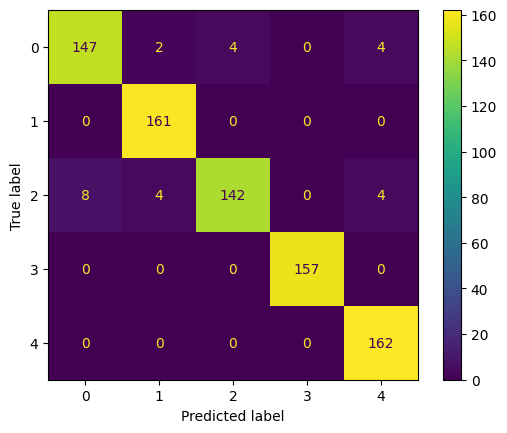

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

model = search.best_estimator_
y_pred = model.predict(X_test)

best_C = search.best_params_['model__C']
print(f"Best C: {best_C}")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix \n{cm}")
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
display.plot()
print(f"Training time: {training_time}")

### Kernel Experiments

Best C: 0.01


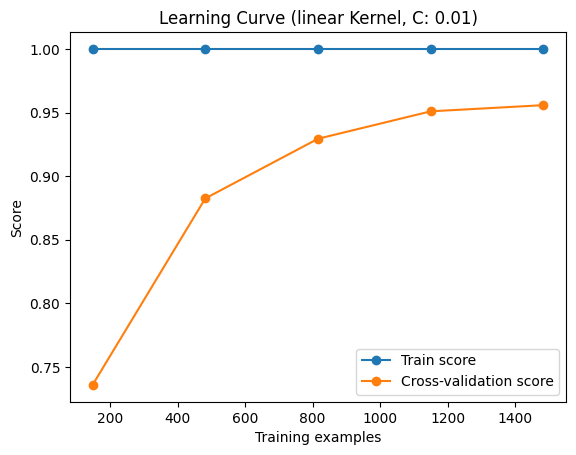

Best C: 1000.0


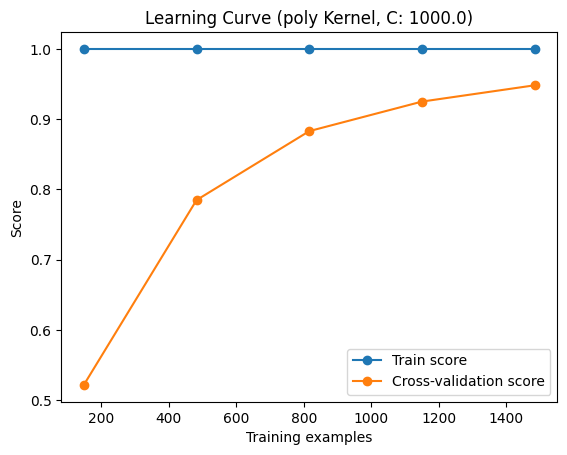

Best C: 1000.0


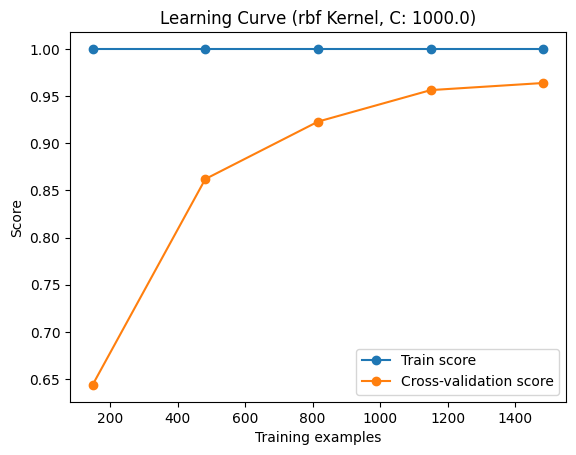

Best C: 0.1


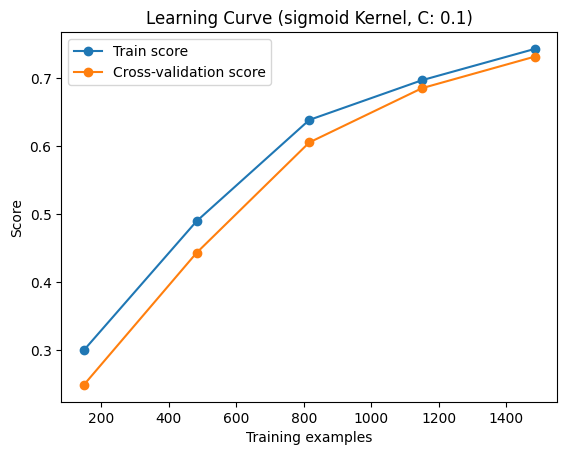

In [ ]:
from sklearn.model_selection import learning_curve

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
  clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(kernel=kernel, random_state=42))])

  param_grid = {
    'model__C': [1e-3,1e-2,1e-1,1e3,1e2,1e1,1e0]
  }

  search = GridSearchCV(clf, param_grid=param_grid, cv=5)
  search.fit(X_train, y_train)

  training_set_sizes = np.linspace(0.1, 1.0, 5)

  train_sizes, train_scores, test_scores = learning_curve(
    search.best_estimator_, X_train, y_train,
    train_sizes=training_set_sizes
  )

  train_scores_mean = np.mean(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)

  print(f"Best C: {search.best_params_['model__C']}")
  plt.figure()
  plt.plot(train_sizes, train_scores_mean, 'o-', label="Train score")
  plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  plt.title(f"Learning Curve ({kernel} Kernel, C: {search.best_params_['model__C']})")
  plt.legend(loc="best")
  plt.show()

